In [293]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response, load_behavior_txt
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
thresh = 0.05 # correlation threshold for selecting important axons
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
cmap = plt.cm.get_cmap('viridis_r')
if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    im_proportion = 0.3
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    im_proportion = 0.2
    
day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
                 [[1,2, 4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
                 [],
                 [[1,2,3,4,5], [6,9,10], [11,15]]]

In [ ]:
def important_axons(stim_w, proportion=0.1):
    # thresh = 0.001
    # axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    # axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
    # idx = np.where(axons_contribution > thresh)[0]
    # non_idx = np.where(axons_contribution <= thresh)[0]
    NA = stim_weights.shape[0]
    axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    axons_contribution_threshold = np.mean(axons_contribution) + np.std(axons_contribution)
    w_sort = np.argsort(axons_contribution)
    NNA = int(proportion*NA)
    idx = w_sort[-NNA:]
    non_idx = w_sort[:(NA-NNA)]
#     idx = np.where(axons_contribution > axons_contribution_threshold)
#     non_idx = np.where(axons_contribution <= axons_contribution_threshold)
    return idx, non_idx

# Weight analysis

In [273]:
day = 8
pre_window = 45
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
iblocks = daily_blocks(data, day)

if len(iblocks)>0:
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for j in iblocks:
        block = data[0, j]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_alllicks = np.vstack(daily_alllicks)

nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
inotnan = np.where(nanflag==0)
daily_responses = daily_responses[inotnan]
daily_cues = daily_cues[inotnan]
daily_outcomes = daily_outcomes[inotnan]
daily_alllicks = daily_alllicks[inotnan]
NT, NA, NF = daily_responses.shape
print(daily_responses.shape)

stim = np.ones(daily_cues.shape)
stim[np.where(daily_cues==2)] = 0 
stim[np.where(daily_cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

spks = daily_responses.reshape(daily_responses.shape[0], -1)
print(spks.shape)

random.seed(0)
np.random.seed(0)
itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
itest = np.setxor1d(np.arange(NT), itrain)


-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
(200, 271, 90)
(200, 24390)


In [275]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], stim[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('accuracy predicting stimulus identity on test set: ', acc)
stim_weights = model.coef_.reshape((NA, NF))
prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(spks[itrain], prelick[itrain])
te_pred = model.predict(spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
prelick_weights = model.coef_.reshape((NA, NF))
print('accuracy predicting prelick on test set: ', acc)
idx, non_idx = important_axons(stim_weights, proportion=im_proportion)

accuracy predicting stimulus identity on test set:  0.6567164179104478
accuracy predicting prelick on test set:  0.8805970149253731


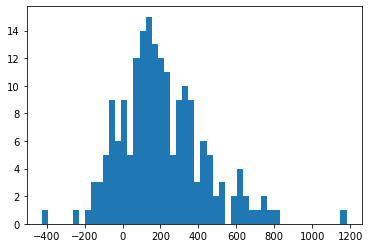

In [264]:
ioutcome = np.where(daily_outcomes == 1)[0]
hit_resp = daily_responses[ioutcome]
hit_resp = hit_resp.transpose(1,0,2)
hit_resp = hit_resp.reshape(NA, -1)
ioutcome = np.where(daily_outcomes == 4)[0]
cr_resp = daily_responses[ioutcome]
cr_resp = cr_resp.transpose(1,0,2)
cr_resp = cr_resp.reshape(NA, -1)
resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)
plt.hist(resp_index, bins=50)
plt.show()

resp_index_threshold = np.mean()
new_idx = np.where(resp_index > resp_index_threshold)[0]
new_non_idx = np.where(resp_index <= resp_index_threshold)[0]

In [159]:
model = LogisticRegression(solver='liblinear', random_state=0)
new_spks = daily_responses[:, new_idx, :]
new_spks = new_spks.reshape(daily_responses.shape[0], -1)
model.fit(new_spks[itrain], stim[itrain])
te_pred = model.predict(new_spks[itest])
acc = np.sum(te_pred == stim[itest]) / len(itest)
print('[day {}, im, NA={}] accuracy predicting stimulus identity on test set: '.format(day, len(new_idx)), acc)
prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(new_spks[itrain], prelick[itrain])
te_pred = model.predict(new_spks[itest])
acc = np.sum(te_pred == prelick[itest]) / len(itest)
print('[day {}, im, NA={}] accuracy predicting prelick on test set: '.format(day, len(new_idx)), acc)

[day 15, im, NA=21] accuracy predicting stimulus identity on test set:  0.8354430379746836
[day 15, im, NA=21] accuracy predicting prelick on test set:  0.7468354430379747


In [198]:
day = 8
pre_window = 45
accs = np.zeros((len(valid_days), 3))
for iday, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)

    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('[day {}, all] accuracy predicting stimulus identity on test set: '.format(day), acc)
    accs[iday, 0] = acc
    stim_weights = model.coef_.reshape((NA, NF))
    idx, non_idx = important_axons(stim_weights)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[day {}, all] accuracy predicting prelick on test set: '.format(day), acc)
    
    model = LogisticRegression(solver='liblinear', random_state=0)
    new_spks = daily_responses[:, idx, :]
    new_spks = new_spks.reshape(daily_responses.shape[0], -1)
    model.fit(new_spks[itrain], stim[itrain])
    te_pred = model.predict(new_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    accs[iday, 1] = acc
    print('[day {}, im, NA={}] accuracy predicting stimulus identity on test set: '.format(day, len(new_idx)), acc)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(new_spks[itrain], prelick[itrain])
    te_pred = model.predict(new_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[day {}, im, NA={}] accuracy predicting prelick on test set: '.format(day, len(new_idx)), acc)

    ioutcome = np.where(daily_outcomes == 1)[0]
    hit_resp = daily_responses[ioutcome]
    hit_resp = hit_resp.transpose(1,0,2)
    hit_resp = hit_resp.reshape(NA, -1)
    ioutcome = np.where(daily_outcomes == 4)[0]
    cr_resp = daily_responses[ioutcome]
    cr_resp = cr_resp.transpose(1,0,2)
    cr_resp = cr_resp.reshape(NA, -1)
    resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)
    resp_index_threshold = np.mean(resp_index) + np.std(resp_index)
    new_idx = np.where(resp_index > resp_index_threshold)[0]
    new_non_idx = np.where(resp_index <= resp_index_threshold)[0]

    model = LogisticRegression(solver='liblinear', random_state=0)
    new_spks = daily_responses[:, new_idx, :]
    new_spks = new_spks.reshape(daily_responses.shape[0], -1)
    model.fit(new_spks[itrain], stim[itrain])
    te_pred = model.predict(new_spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    accs[iday, 2] = acc
    print('[day {}, new im, NA={}] accuracy predicting stimulus identity on test set: '.format(day, len(new_idx)), acc)
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(new_spks[itrain], prelick[itrain])
    te_pred = model.predict(new_spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    print('[day {}, new im, NA={}] accuracy predicting prelick on test set: '.format(day, len(new_idx)), acc)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, all] accuracy predicting stimulus identity on test set:  0.49
[day 1, all] accuracy predicting prelick on test set:  0.82
[day 1, im, NA=42] accuracy predicting stimulus identity on test set:  0.54
[day 1, im, NA=42] accuracy predicting prelick on test set:  0.79
[day 1, new im, NA=61] accuracy predicting stimulus identity on test set:  0.46
[day 1, new im, NA=61] accuracy predicting prelick on test set:  0.83
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, all] accuracy predicting stimulus identity on test set:  0.67
[day 2, all] accuracy predicting prelick on test set:  0.79
[day 2, im, NA=61] accuracy predicting stimulus identity on test set:  0.59
[day 2, im, NA=61] accuracy predicting prelick on test set:  0.75
[day 2, new im, NA=48] accuracy predicting stimulus identity on test set:  0.56
[day 2, new im, NA=48] accuracy pred

[day 23, all] accuracy predicting stimulus identity on test set:  0.79
[day 23, all] accuracy predicting prelick on test set:  0.77
[day 23, im, NA=42] accuracy predicting stimulus identity on test set:  0.79
[day 23, im, NA=42] accuracy predicting prelick on test set:  0.75
[day 23, new im, NA=42] accuracy predicting stimulus identity on test set:  0.82
[day 23, new im, NA=42] accuracy predicting prelick on test set:  0.75
-------------------day 24---------------------
******** predict with activities in [T-45, T+45]
[day 24, all] accuracy predicting stimulus identity on test set:  0.6417910447761194
[day 24, all] accuracy predicting prelick on test set:  0.7164179104477612
[day 24, im, NA=42] accuracy predicting stimulus identity on test set:  0.5970149253731343
[day 24, im, NA=42] accuracy predicting prelick on test set:  0.7164179104477612
[day 24, new im, NA=25] accuracy predicting stimulus identity on test set:  0.5223880597014925
[day 24, new im, NA=25] accuracy predicting preli

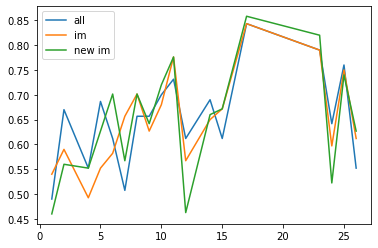

In [199]:
plt.plot(valid_days, accs[:, 0], label='all')
plt.plot(valid_days, accs[:, 1], label='im')
plt.plot(valid_days, accs[:, 2], label='new im')
plt.legend()

In [ ]:
# based on the correlation

all_spks = daily_responses.transpose(1, 0, 2)
NA = all_spks.shape[0]
all_spks = all_spks.reshape(NA, -1)
im_avg_resp = np.mean(all_spks[idx], axis=0)

a = np.repeat(im_avg_resp.reshape(1, len(im_avg_resp)), NA, axis=0)
z = zscore(all_spks, axis=1)
D = all_spks.shape[-1]
corrs = np.matmul(a, z.T).diagonal() / D

thresh = np.mean(corrs) + np.std(corrs)
new_idx = np.where(corrs > thresh)[0]
isort = np.argsort(corrs[new_idx])
new_idx = new_idx[isort]
new_non_idx = np.where(corrs <= thresh)[0]
isort = np.argsort(corrs[new_non_idx])
new_non_idx = new_non_idx[isort]

plt.hist(corrs, bins=50, alpha=0.4, label='all')
plt.hist(corrs[idx], bins=50, alpha=0.4, label='im')
plt.hist(corrs[new_idx], bins=50, alpha=0.4, label='new im')
plt.legend()
plt.title('day {}, correlation distibution (with importnant average), {}'.format(day, mouse_name))
plt.show()

In [178]:
isort_idx = np.argsort(stim_weights[idx])
isort_non_idx = np.argsort(stim_weights[non_idx])
print(isort_idx.shape)

(18, 90)


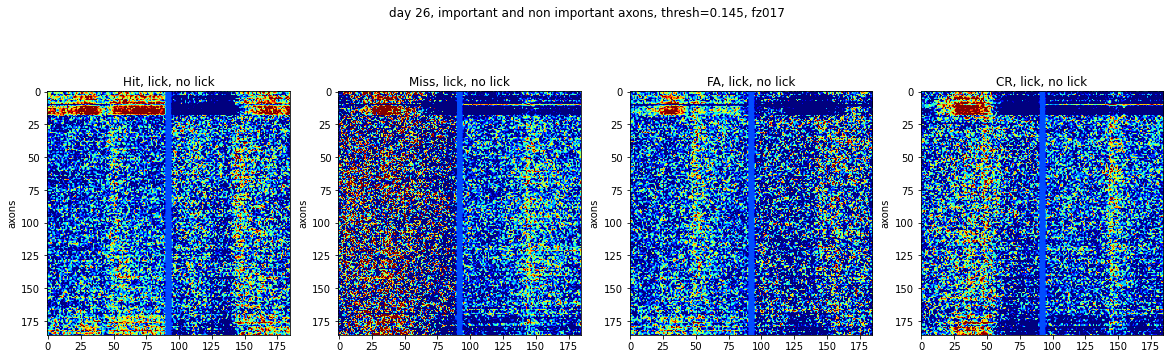

In [179]:
axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
isort_idx = np.argsort(axons_contribution[idx])
isort_non_idx = np.argsort(axons_contribution[non_idx])
sorted_idx = np.concatenate((idx[isort_idx], non_idx[isort_non_idx]), axis=None)
NN = len(sorted_idx)
plot_spks = daily_responses[:, sorted_idx, :]
plt.figure(figsize=(20,6))
for outcome_index in range(1,5):
    all_resp = np.zeros((NN, 90*2+5))
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    oresp = plot_spks[ioutcome]

    lick = daily_alllicks[ioutcome] 
    n_prelicks = np.sum(lick[:, 15:30], axis=1)
    lick_idx = np.where(n_prelicks != 0)[0] # with prelick
    resp = oresp[lick_idx]
    all_resp[:, :90] = resp.mean(axis=0)

    nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
    resp = oresp[nolick_idx]
    all_resp[:, (90+5):] = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)

    plt.subplot(1,4,outcome_index)
    plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
    plt.ylabel('axons')
    # plt.colorbar()
    # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
    plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
plt.suptitle('day {}, important and non important axons, thresh={:.3f}, {}'.format(day, thresh, mouse_name))
# plt.colorbar()
plt.show()

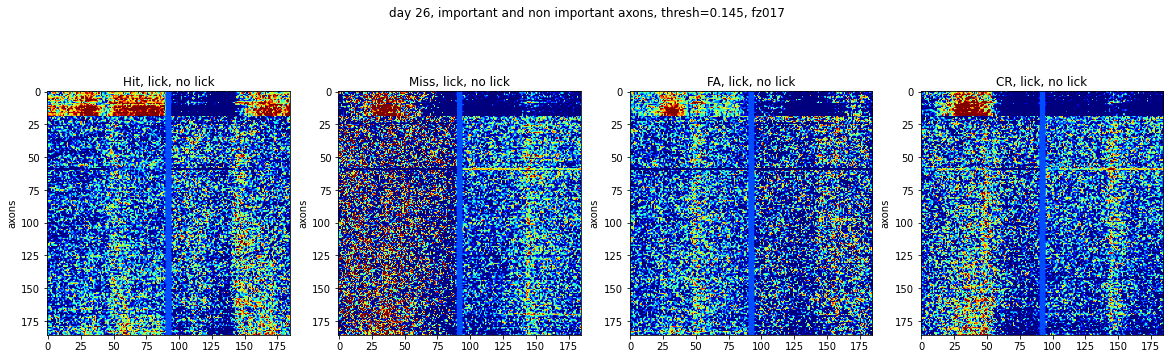

In [180]:
sorted_idx = np.concatenate((new_idx, new_non_idx), axis=None)
NN = len(sorted_idx)
plot_spks = daily_responses[:, sorted_idx, :]
plt.figure(figsize=(20,6))
for outcome_index in range(1,5):
    all_resp = np.zeros((NN, 90*2+5))
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    oresp = plot_spks[ioutcome]

    lick = daily_alllicks[ioutcome] 
    n_prelicks = np.sum(lick[:, 15:30], axis=1)
    lick_idx = np.where(n_prelicks != 0)[0] # with prelick
    resp = oresp[lick_idx]
    all_resp[:, :90] = resp.mean(axis=0)

    nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
    resp = oresp[nolick_idx]
    all_resp[:, (90+5):] = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)

    plt.subplot(1,4,outcome_index)
    plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
    plt.ylabel('axons')
    # plt.colorbar()
    # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
    plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
plt.suptitle('day {}, important and non important axons, thresh={:.3f}, {}'.format(day, thresh, mouse_name))
# plt.colorbar()
plt.show()

In [183]:
print(np.sort(idx))
print(np.sort(new_idx))

[ 24  54  69  84 118 119 120 121 122 123 124 125 126 129 152 155 159 180]
[  0   1 118 119 120 121 122 123 124 125 126 128 129 152 153 155 156 159
 180]


# raw spks

In [276]:
daily_spks = []
daily_behav = []
daily_licks = []
for i in iblocks:
    block = data[0, i]
    behavior = block['behavdata']
    raw_spks = block['imagingdata']
    xpos = block['xcoord']
    ypos = block['ycoord']
    xpos = np.hstack((xpos[0, 0], xpos[0, 1])).squeeze()
    ypos = np.hstack((ypos[0, 0], ypos[0, 1])).squeeze()
    NN, NT = raw_spks.shape
    print(raw_spks.shape)
    spks = zscore(raw_spks, axis=1)
    daily_spks.append(spks)
    daily_behav.append(behavior)
    behavior = block['behavdata']
    licks = behavior[3]
    daily_licks.append(licks)

daily_spks = np.hstack(daily_spks)
print('day {} spk shape: {}'.format(day, daily_spks.shape))

daily_behav = np.hstack(daily_behav)
print('day {} behavior shape: {}'.format(day, daily_behav.shape))

daily_licks = np.hstack(daily_licks)
print('day {} lick shape: {}'.format(day, daily_licks.shape))

print('day {} xpos shape: {}'.format(day, xpos.shape))

(271, 14223)
(271, 12030)
day 8 spk shape: (271, 26253)
day 8 behavior shape: (4, 26253)
day 8 lick shape: (26253,)
day 8 xpos shape: (271,)


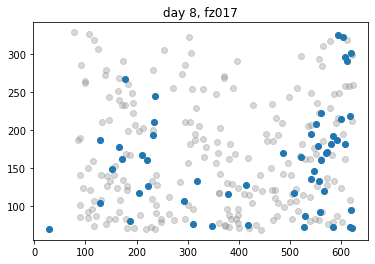

In [278]:
for i in range(len(ypos)):
    ypos[i] = int(np.mean(ypos[i]))
    xpos[i] = int(np.mean(xpos[i]))
plt.scatter(xpos, ypos, alpha=0.3, color='gray')
plt.scatter(xpos[idx], ypos[idx])
plt.title('day {}, {}'.format(day, mouse_name))

xpos = xpos.astype(None)
xpos = xpos.astype(int)
ypos = ypos.astype(None)
ypos = ypos.astype(int)

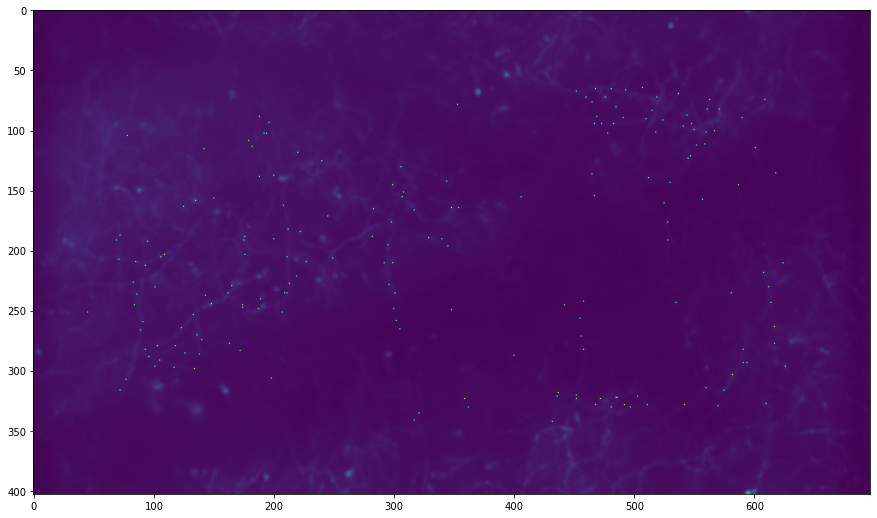

In [259]:
img = block['MeanImg']
img1 = img[0, 0] / np.max(img[0, 0])
img2 = img[0, 1] / np.max(img[0, 1])
add_img = np.zeros(img1.shape)
add_img[ypos, xpos] = 1.0
plt.figure(figsize=(15, 9))
plt.imshow(img1+add_img)

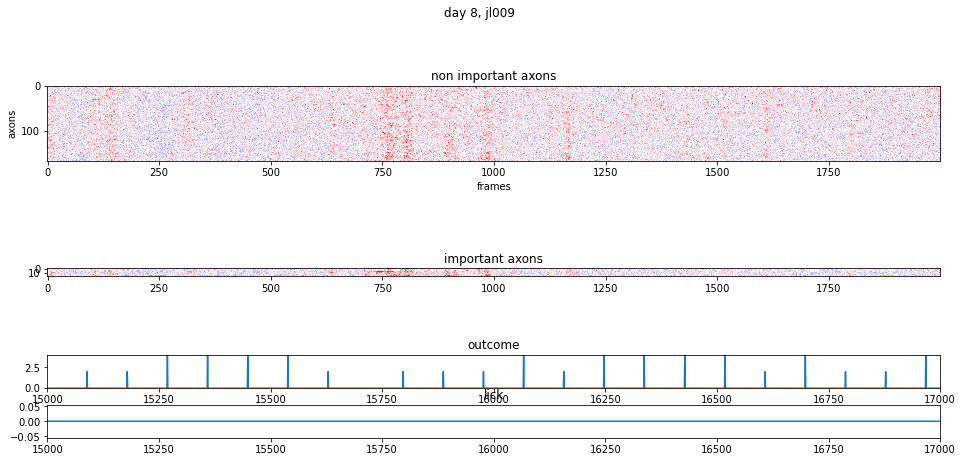

In [270]:
tmin = 15000
tmax = 17000
trange = np.arange(tmin, tmax)
f, (a0, a1, a2, a3) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [4, 4, 1,1]}, figsize=(16,7))
a0.imshow(daily_spks[np.ix_(non_idx, trange)], cmap='bwr', vmin=-2, vmax=2)
a0.set_xlabel('frames')
a0.set_ylabel('axons')
a0.set_title('non important axons')
# plt.colorbar()
a1.imshow(daily_spks[np.ix_(idx, trange)], cmap='bwr', vmin=-2, vmax=2)
a0.set_xlabel('frames')
a0.set_ylabel('axons')
a1.set_title('important axons')
a2.plot(trange, daily_behav[1, trange])
a2.set_xlim([tmin, tmax])
a2.set_title('outcome')
a2.set_ylim([0, 4])
a3.plot(trange, daily_licks[trange])
a3.set_xlim([tmin, tmax])
a3.set_title('lick')
plt.suptitle('day {}, {}'.format(day, mouse_name))
plt.show()

# location all

In [289]:
day = 8
pre_window = 45
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)

    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)
    print(spks.shape)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    print('accuracy predicting stimulus identity on test set: ', acc)
    stim_weights = model.coef_.reshape((NA, NF))
    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], prelick[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == prelick[itest]) / len(itest)
    prelick_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting prelick on test set: ', acc)
    
    idx, non_idx = important_axons(stim_weights, proportion=im_proportion)
    axon_contribution = np.mean(stim_weights[:, 45:], axis=1)

    daily_spks = []
    daily_behav = []
    daily_licks = []
    for i in iblocks:
        block = data[0, i]
        behavior = block['behavdata']
        raw_spks = block['imagingdata']
        xpos = block['xcoord']
        ypos = block['ycoord']
        xpos = np.hstack((xpos[0, 0], xpos[0, 1])).squeeze()
        ypos = np.hstack((ypos[0, 0], ypos[0, 1])).squeeze()
        NN, NT = raw_spks.shape
        print(raw_spks.shape)
        spks = zscore(raw_spks, axis=1)
        daily_spks.append(spks)
        daily_behav.append(behavior)
        behavior = block['behavdata']
        licks = behavior[3]
        daily_licks.append(licks)

    daily_spks = np.hstack(daily_spks)
    print('day {} spk shape: {}'.format(day, daily_spks.shape))

    daily_behav = np.hstack(daily_behav)
    print('day {} behavior shape: {}'.format(day, daily_behav.shape))

    daily_licks = np.hstack(daily_licks)
    print('day {} lick shape: {}'.format(day, daily_licks.shape))

    print('day {} xpos shape: {}'.format(day, xpos.shape))


    for i in range(len(ypos)):
        ypos[i] = int(np.mean(ypos[i]))
        xpos[i] = int(np.mean(xpos[i]))
    axon_contribution = axon_contribution / np.max(np.abs(axon_contribution))
    plt.scatter(xpos, ypos, c=axon_contribution, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    # plt.scatter(xpos[idx], ypos[idx])
    plt.title('day {}, {}'.format(day, mouse_name))

    xpos = xpos.astype(None)
    xpos = xpos.astype(int)
    ypos = ypos.astype(None)
    ypos = ypos.astype(int)
    fig_save_path = os.path.join('figures', 'cortex_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 447, 90)
(300, 40230)
accuracy predicting stimulus identity on test set:  0.49
accuracy predicting prelick on test set:  0.82
(447, 11757)
(447, 11357)
(447, 12697)
day 1 spk shape: (447, 35811)
day 1 behavior shape: (4, 35811)
day 1 lick shape: (35811,)
day 1 xpos shape: (447,)
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 386, 90)
(300, 34740)
accuracy predicting stimulus identity on test set:  0.67
accuracy predicting prelick on test set:  0.79
(386, 13159)
(386, 11210)
(386, 9513)
day 2 spk shape: (386, 33882)
day 2 behavior shape: (4, 33882)
day 2 lick shape: (33882,)
day 2 xpos shape: (386,)
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
(200, 313, 90)
(200, 28170)
accuracy predicting stimulus identity on test set:  0.5522388059701493
accuracy predicting prelick on test set:  0.7

## pure motor driven axons

In [294]:
day = 8
pre_window = 45
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)

    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape
    print(daily_responses.shape)

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    ioutcome = np.where(daily_outcomes == 1)[0]
    hit_resp = daily_responses[ioutcome]
    hit_resp = hit_resp.transpose(1,0,2)
    hit_resp = hit_resp.reshape(NA, -1)
    ioutcome = np.where(daily_outcomes == 4)[0]
    cr_resp = daily_responses[ioutcome]
    cr_resp = cr_resp.transpose(1,0,2)
    cr_resp = cr_resp.reshape(NA, -1)
    resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)
    
    resp_index_threshold = np.mean(resp_index) + np.std(resp_index)
    idx = np.where(resp_index > resp_index_threshold)[0]
    non_idx = np.where(resp_index <= resp_index_threshold)[0]

    daily_spks = []
    daily_behav = []
    daily_licks = []
    for i in iblocks:
        block = data[0, i]
        behavior = block['behavdata']
        raw_spks = block['imagingdata']
        xpos = block['xcoord']
        ypos = block['ycoord']
        xpos = np.hstack((xpos[0, 0], xpos[0, 1])).squeeze()
        ypos = np.hstack((ypos[0, 0], ypos[0, 1])).squeeze()
        NN, NT = raw_spks.shape
        print(raw_spks.shape)
        spks = zscore(raw_spks, axis=1)
        daily_spks.append(spks)
        daily_behav.append(behavior)
        behavior = block['behavdata']
        licks = behavior[3]
        daily_licks.append(licks)

    daily_spks = np.hstack(daily_spks)
    print('day {} spk shape: {}'.format(day, daily_spks.shape))

    daily_behav = np.hstack(daily_behav)
    print('day {} behavior shape: {}'.format(day, daily_behav.shape))

    daily_licks = np.hstack(daily_licks)
    print('day {} lick shape: {}'.format(day, daily_licks.shape))

    print('day {} xpos shape: {}'.format(day, xpos.shape))


    for i in range(len(ypos)):
        ypos[i] = int(np.mean(ypos[i]))
        xpos[i] = int(np.mean(xpos[i]))
    axon_contribution = axon_contribution / np.max(np.abs(axon_contribution))
    plt.scatter(xpos, ypos, color='gray', alpha=0.3)
    plt.scatter(xpos[idx], ypos[idx], label='pure motor driven')
    plt.legend()
    plt.title('day {}, {}'.format(day, mouse_name))

    xpos = xpos.astype(None)
    xpos = xpos.astype(int)
    ypos = ypos.astype(None)
    ypos = ypos.astype(int)
    fig_save_path = os.path.join('figures', 'cortex-motor-driven-axons_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
(300, 175, 90)
(175, 13540)
(175, 11474)
(175, 9940)
day 1 spk shape: (175, 34954)
day 1 behavior shape: (4, 34954)
day 1 lick shape: (34954,)
day 1 xpos shape: (175,)
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
(300, 141, 90)
(141, 12694)
(141, 11763)
(141, 10724)
day 2 spk shape: (141, 35181)
day 2 behavior shape: (4, 35181)
day 2 lick shape: (35181,)
day 2 xpos shape: (141,)
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
(300, 205, 90)
(205, 12837)
(205, 11079)
(205, 9749)
day 3 spk shape: (205, 33665)
day 3 behavior shape: (4, 33665)
day 3 lick shape: (33665,)
day 3 xpos shape: (205,)
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
(200, 158, 90)
(158, 12982)
(158, 11402)
day 5 spk shape: (158, 24384)
day 5 behavior shape: (4, 24384)
day 5 lick 

# day 1 response

# all

In [207]:
block = data[0, 1]
xcoord = block['xcoord']
print(xcoord.shape)
print(xcoord[0, 0].shape, xcoord[0, 1].shape)
raw_spks = block['imagingdata']
print(raw_spks.shape)
xpos = block['xcoord']
ypos = block['ycoord']
xpos = np.hstack((xpos[0, 0], xpos[0, 1])).squeeze()
print(xpos.shape)

(1, 2)
(1, 233) (1, 214)
(447, 11357)
(447,)


In [153]:
day = 12
pre_window = 45
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False, remove=True)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    stim_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)

#     ioutcome = np.where(daily_outcomes == 1)[0]
#     hit_resp = daily_responses[ioutcome]
#     hit_resp = hit_resp.transpose(1,0,2)
#     hit_resp = hit_resp.reshape(NA, -1)
#     ioutcome = np.where(daily_outcomes == 4)[0]
#     cr_resp = daily_responses[ioutcome]
#     cr_resp = cr_resp.transpose(1,0,2)
#     cr_resp = cr_resp.reshape(NA, -1)
#     resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)
    
#     resp_index_threshold = 2*np.abs(np.min(resp_index))
#     idx = np.where(resp_index > resp_index_threshold)[0]
#     non_idx = np.where(resp_index <= resp_index_threshold)[0]

    idx, non_idx = important_axons(stim_weights, proportion=0.1)
    all_spks = daily_responses.transpose(1, 0, 2)
    NA = all_spks.shape[0]
    all_spks = all_spks.reshape(NA, -1)
    im_avg_resp = np.mean(all_spks[idx], axis=0)

    a = np.repeat(im_avg_resp.reshape(1, len(im_avg_resp)), NA, axis=0)
    z = zscore(all_spks, axis=1)
    D = all_spks.shape[-1]
    corrs = np.matmul(a, z.T).diagonal() / D

    plt.hist(corrs, bins=50, alpha=0.5, label='all')
    plt.hist(corrs[idx], bins=50, alpha=0.5, label='important')
    plt.xlim([-0.1, 0.5])
    plt.legend()
    plt.title('day {}, correlation distibution (with importnant average), {}'.format(day, mouse_name))
    fig_save_path = os.path.join('figures', 'corr_distribution_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

    thresh = 0.05
    new_idx = np.where(corrs > thresh)[0]
    isort = np.argsort(corrs[new_idx])
    new_idx = new_idx[isort]
    new_non_idx = np.where(corrs <= thresh)[0]
    isort = np.argsort(corrs[new_non_idx])
    new_non_idx = new_non_idx[isort]
    sorted_idx = np.concatenate((new_idx, new_non_idx), axis=None)
    NN = len(sorted_idx)
    plot_spks = daily_responses[:, sorted_idx, :]
    plt.figure(figsize=(20,6))
    for outcome_index in range(1,5):
        all_resp = np.zeros((NN, 90*2+5))
        ioutcome = np.where(daily_outcomes == outcome_index)[0]
        oresp = plot_spks[ioutcome]

        lick = daily_alllicks[ioutcome] 
        n_prelicks = np.sum(lick[:, 15:30], axis=1)
        lick_idx = np.where(n_prelicks != 0)[0] # with prelick
        resp = oresp[lick_idx]
        all_resp[:, :90] = resp.mean(axis=0)

        nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
        resp = oresp[nolick_idx]
        all_resp[:, (90+5):] = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)

        plt.subplot(1,4,outcome_index)
        plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
        plt.ylabel('axons')
        # plt.colorbar()
        # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
        plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
    plt.suptitle('day {}, important and non important axons, thresh={:.3f}, {}'.format(day, thresh, mouse_name))
    fig_save_path = os.path.join('figures', 'im_nonim_axon_hitmap_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 34/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6853932584269663
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.71
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 37/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6931818181818182
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/3167623056.py:109: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 23/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6666666666666666
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 44/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.7692307692307693


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/3167623056.py:109: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 54/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.5714285714285714


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/3167623056.py:109: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.67


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/3167623056.py:109: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 64/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.810126582278481


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/3167623056.py:109: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


## resp index distribution (pure motor driven axons)

In [154]:
day = 12
pre_window = 45
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False, remove=True)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses.reshape(daily_responses.shape[0], -1)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    stim_weights = model.coef_.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)

    ioutcome = np.where(daily_outcomes == 1)[0]
    hit_resp = daily_responses[ioutcome]
    hit_resp = hit_resp.transpose(1,0,2)
    hit_resp = hit_resp.reshape(NA, -1)
    ioutcome = np.where(daily_outcomes == 4)[0]
    cr_resp = daily_responses[ioutcome]
    cr_resp = cr_resp.transpose(1,0,2)
    cr_resp = cr_resp.reshape(NA, -1)
    resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)
    
    resp_index_threshold = np.mean(resp_index) + np.std(resp_index)
    idx = np.where(resp_index > resp_index_threshold)[0]
    non_idx = np.where(resp_index <= resp_index_threshold)[0]

    plt.hist(resp_index, bins=50, alpha=0.5, label='all')
    plt.hist(resp_index[idx], bins=50, alpha=0.5, label='important')
    plt.legend()
    plt.title('day {}, resp index distibution, {}'.format(day, mouse_name))
    fig_save_path = os.path.join('figures', 'resp-index_distribution_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

    sorted_idx = np.concatenate((idx, non_idx), axis=None)
    NN = len(sorted_idx)
    plot_spks = daily_responses[:, sorted_idx, :]
    plt.figure(figsize=(20,6))
    for outcome_index in range(1,5):
        all_resp = np.zeros((NN, 90*2+5))
        ioutcome = np.where(daily_outcomes == outcome_index)[0]
        oresp = plot_spks[ioutcome]

        lick = daily_alllicks[ioutcome] 
        n_prelicks = np.sum(lick[:, 15:30], axis=1)
        lick_idx = np.where(n_prelicks != 0)[0] # with prelick
        resp = oresp[lick_idx]
        all_resp[:, :90] = resp.mean(axis=0)

        nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
        resp = oresp[nolick_idx]
        all_resp[:, (90+5):] = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)

        plt.subplot(1,4,outcome_index)
        plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
        plt.ylabel('axons')
        # plt.colorbar()
        # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
        plt.title('{}, lick, no lick'.format(outcome_list[outcome_index-1]))
    plt.suptitle('day {}, important and non important axons, thresh={:.3f}, {}'.format(day, thresh, mouse_name))
    fig_save_path = os.path.join('figures', 'lick-driven_im_nonim_axon_hitmap_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 34/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6853932584269663
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.71
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 37/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6931818181818182
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/682786101.py:90: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 23/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.6666666666666666
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 44/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.7692307692307693


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/682786101.py:90: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 54/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.5714285714285714


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/682786101.py:90: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.67


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/682786101.py:90: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 64/100 trials with window size 20
accuracy predicting stimulus identity on test set:  0.810126582278481


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_34884/682786101.py:90: RuntimeWarning: Mean of empty slice.
  all_resp[:, :90] = resp.mean(axis=0)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


# average response

In [149]:
resp_lick_all_im = np.zeros((len(valid_days), 4,  NF))
resp_nolick_all_im = np.zeros((len(valid_days),4,  NF))
resp_lick_all_nonim = np.zeros((len(valid_days), 4,  NF))
resp_nolick_all_nonim = np.zeros((len(valid_days),4,  NF))
resp_all_im = np.zeros((len(valid_days),4,  NF))
resp_all_nonim = np.zeros((len(valid_days),4,  NF))
for iday, day in enumerate(valid_days):
    resp_lick_sum_im = np.zeros((4, NF))
    resp_nolick_sum_im = np.zeros((4, NF))
    resp_lick_sum_nonim = np.zeros((4, NF))
    resp_nolick_sum_nonim = np.zeros((4, NF))
    resp_all_sum_im = np.zeros((4, NF))
    resp_all_sum_nonim = np.zeros((4, NF))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, window=[pre_window, 45])
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        NN = daily_responses.shape[1]

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]
        NT, NA, NF = daily_responses.shape

        stim = np.ones(daily_cues.shape)
        stim[np.where(daily_cues==2)] = 0 
        stim[np.where(daily_cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

        spks = daily_responses.reshape(daily_responses.shape[0], -1)

        random.seed(0)
        np.random.seed(0)
        itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
        itest = np.setxor1d(np.arange(NT), itrain)

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(spks[itrain], stim[itrain])
        te_pred = model.predict(spks[itest])
        acc = np.sum(te_pred == stim[itest]) / len(itest)
        print('accuracy predicting stimulus identity on test set: ', acc)
        stim_weights = model.coef_.reshape((NA, NF))

#         idx, non_idx = important_axons(stim_weights, proportion=im_proportion)
            
#         all_spks = daily_responses.transpose(1, 0, 2)
#         NA = all_spks.shape[0]
#         all_spks = all_spks.reshape(NA, -1)
#         im_avg_resp = np.mean(all_spks[idx], axis=0)

#         a = np.repeat(im_avg_resp.reshape(1, len(im_avg_resp)), NA, axis=0)
#         z = zscore(all_spks, axis=1)
#         D = all_spks.shape[-1]
#         corrs = np.matmul(a, z.T).diagonal() / D

#         idx = np.where(corrs > thresh)[0]
#         non_idx = np.where(corrs <= thresh)[0]
        
        
        ioutcome = np.where(daily_outcomes == 1)[0]
        hit_resp = daily_responses[ioutcome]
        hit_resp = hit_resp.transpose(1,0,2)
        hit_resp = hit_resp.reshape(NA, -1)
        ioutcome = np.where(daily_outcomes == 4)[0]
        cr_resp = daily_responses[ioutcome]
        cr_resp = cr_resp.transpose(1,0,2)
        cr_resp = cr_resp.reshape(NA, -1)
        resp_index = np.sum(hit_resp[:, 45:], axis=1) - np.sum(cr_resp[:, 45:], axis=1)

        resp_index_threshold = np.mean(resp_index) + np.std(resp_index)
        idx = np.where(resp_index > resp_index_threshold)[0]
        non_idx = np.where(resp_index <= resp_index_threshold)[0]


        spks = spks.reshape(NT, NA, NF)
        NNA = len(idx)

        axon_spks = spks[:, idx, :] 
        # axon_spks = axon_spks.reshape(NT, -1)
        # non_axon_spks = spks[:, non_idx, :]
        # non_axon_spks = non_axon_spks.reshape(NT, -1)

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = axon_spks[ioutcome]

            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, 15:30], axis=1)
            lick_idx = np.where(n_prelicks != 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NF)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks == 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NF)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]

            resp = resp.reshape(-1, NF)
            all_resp = np.mean(resp, axis=0)

            x = np.arange(NF)
            # resp_lick = savgol_filter(resp_lick, 13, 2)
            # resp_nolick = savgol_filter(resp_nolick, 13, 2)
            resp_lick_sum_im[outcome_index-1] = resp_lick
            resp_nolick_sum_im[outcome_index-1] = resp_nolick
            resp_all_sum_im[outcome_index-1] = all_resp
            
        NNA = len(non_idx)
        axon_spks = spks[:, non_idx, :] 

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = axon_spks[ioutcome]

            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, 15:30], axis=1)
            lick_idx = np.where(n_prelicks != 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NF)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks == 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NF)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]

            resp = resp.reshape(-1, NF)
            all_resp = np.mean(resp, axis=0)

            x = np.arange(NF)
            # resp_lick = savgol_filter(resp_lick, 13, 2)
            # resp_nolick = savgol_filter(resp_nolick, 13, 2)
            resp_lick_sum_nonim[outcome_index-1] = resp_lick
            resp_nolick_sum_nonim[outcome_index-1] = resp_nolick
            resp_all_sum_nonim[outcome_index-1] = all_resp
            

    resp_lick_all_im[iday] = resp_lick_sum_im
    resp_nolick_all_im[iday] = resp_nolick_sum_im
    resp_lick_all_nonim[iday] = resp_lick_sum_nonim
    resp_nolick_all_nonim[iday] = resp_nolick_sum_nonim
    resp_all_im[iday] = resp_all_sum_im
    resp_all_nonim[iday] = resp_all_sum_nonim
    

accuracy predicting stimulus identity on test set:  0.61
accuracy predicting stimulus identity on test set:  0.71
accuracy predicting stimulus identity on test set:  0.67
accuracy predicting stimulus identity on test set:  0.6716417910447762


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


accuracy predicting stimulus identity on test set:  0.7
accuracy predicting stimulus identity on test set:  0.6716417910447762


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


accuracy predicting stimulus identity on test set:  0.582089552238806


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


accuracy predicting stimulus identity on test set:  0.67


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


accuracy predicting stimulus identity on test set:  0.76


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


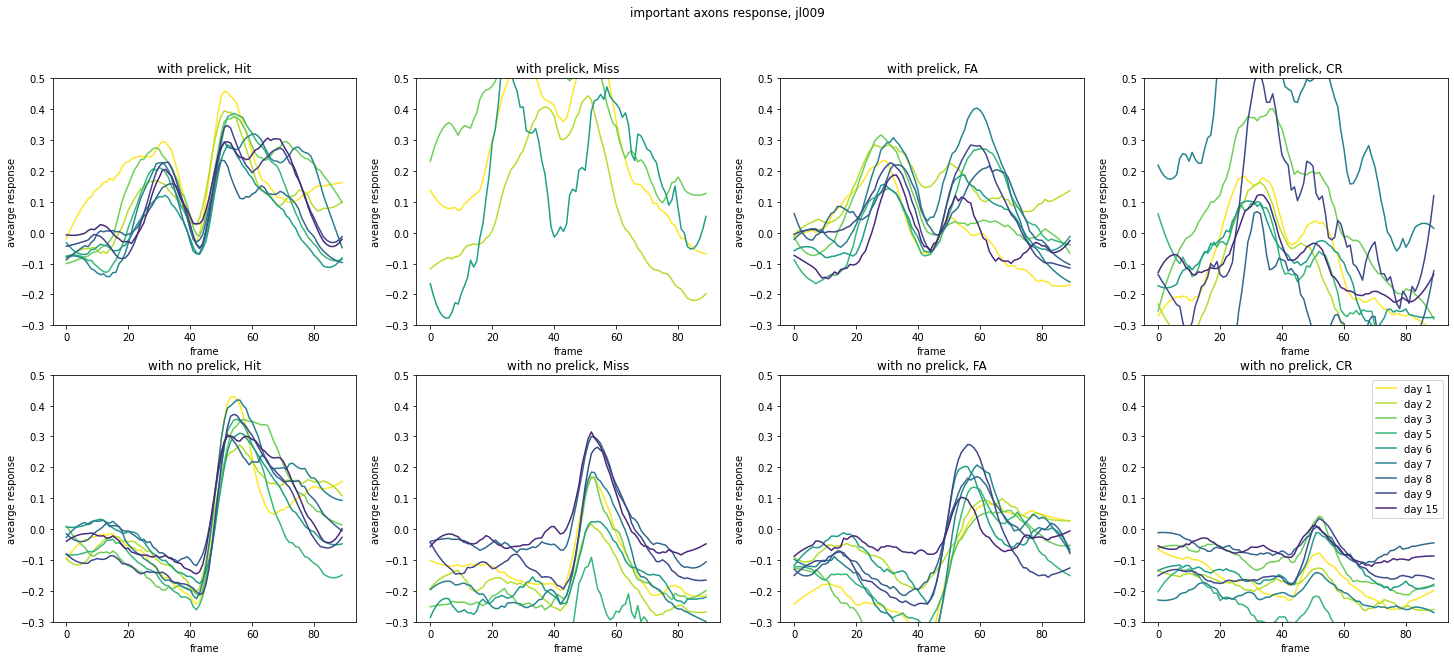

In [150]:
im = True
if im:
    resp_lick_all = resp_lick_all_im
    resp_nolick_all = resp_nolick_all_im
else:
    resp_lick_all = resp_lick_all_nonim
    resp_nolick_all = resp_nolick_all_nonim
cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for iday, days in enumerate(valid_days):
        y = resp_lick_all[iday, outcome_index]
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='dat {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('with prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    
    plt.subplot(2,4,5+outcome_index)
    for iday, day in enumerate(valid_days):
        y = resp_nolick_all[iday, outcome_index]
        # min_resp = np.min(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='day {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('with no prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
plt.legend(bbox_to_anchor=(1, 1))
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))

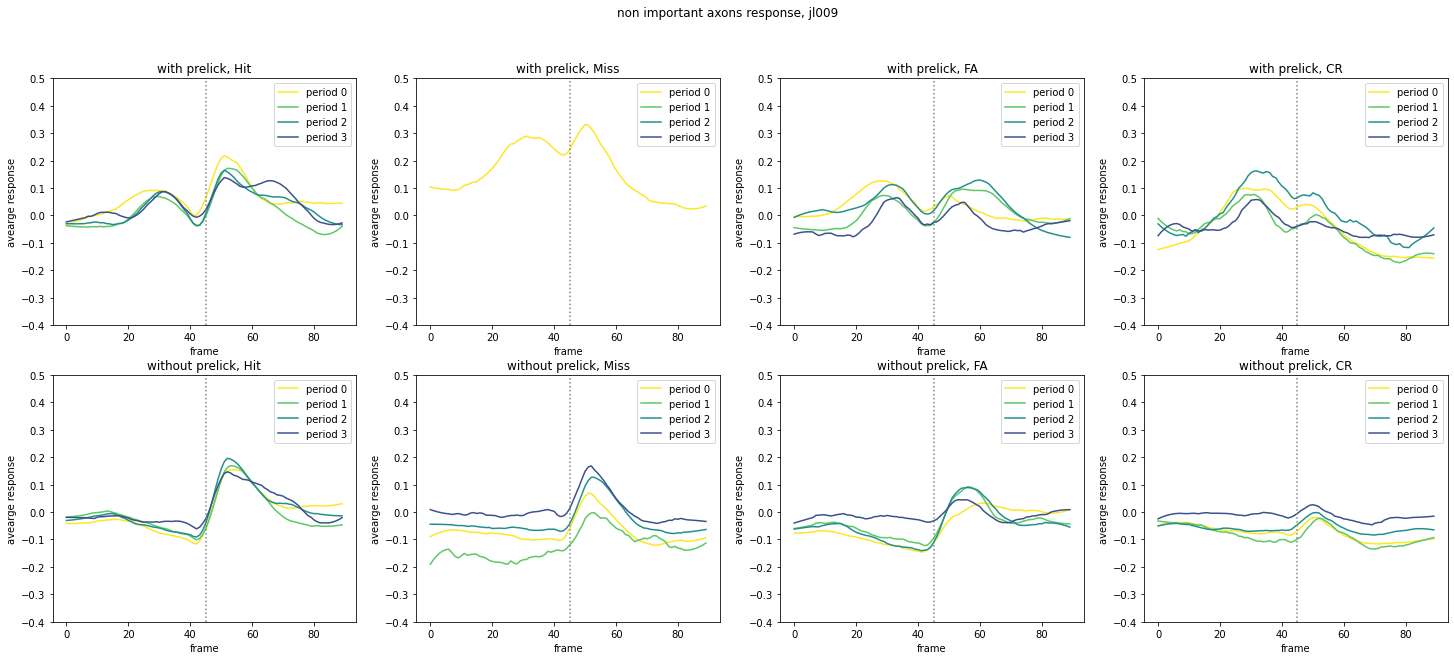

In [152]:
im = False
if im:
    resp_lick_all = resp_lick_all_im
    resp_nolick_all = resp_nolick_all_im
else:
    resp_lick_all = resp_lick_all_nonim
    resp_nolick_all = resp_nolick_all_nonim
day_groups = day_groups_all[mouse_id]
resp_all_lick = np.zeros((len(day_groups), 4,  NF))
resp_all_nolick = np.zeros((len(day_groups), 4,  NF))
for outcome_index in range(4):
    for igroup, days in enumerate(day_groups):
        rsum_lick = np.zeros(NF)
        rsum_nolick = np.zeros(NF)
        for d in days:
            iday = np.where(d==np.array(valid_days))
            y = resp_lick_all[iday, outcome_index]
            rsum_lick += np.squeeze(y)
            y = resp_nolick_all[iday, outcome_index]
            rsum_nolick += np.squeeze(y)
        rsum_lick = rsum_lick/len(days)
        resp_all_lick[igroup, outcome_index] = rsum_lick
        rsum_nolick = rsum_nolick/len(days)
        resp_all_nolick[igroup, outcome_index] = rsum_nolick

cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for igroup, days in enumerate(day_groups):
        y = resp_all_lick[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.axvline(x=45, linestyle=':', color='gray')
    plt.title('with prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.4, 0.5])
    
    plt.subplot(2,4,outcome_index+5)
    for igroup, days in enumerate(day_groups):
        y = resp_all_nolick[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.axvline(x=45, linestyle=':', color='gray')
    plt.title('without prelick, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.4, 0.5])
    
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))

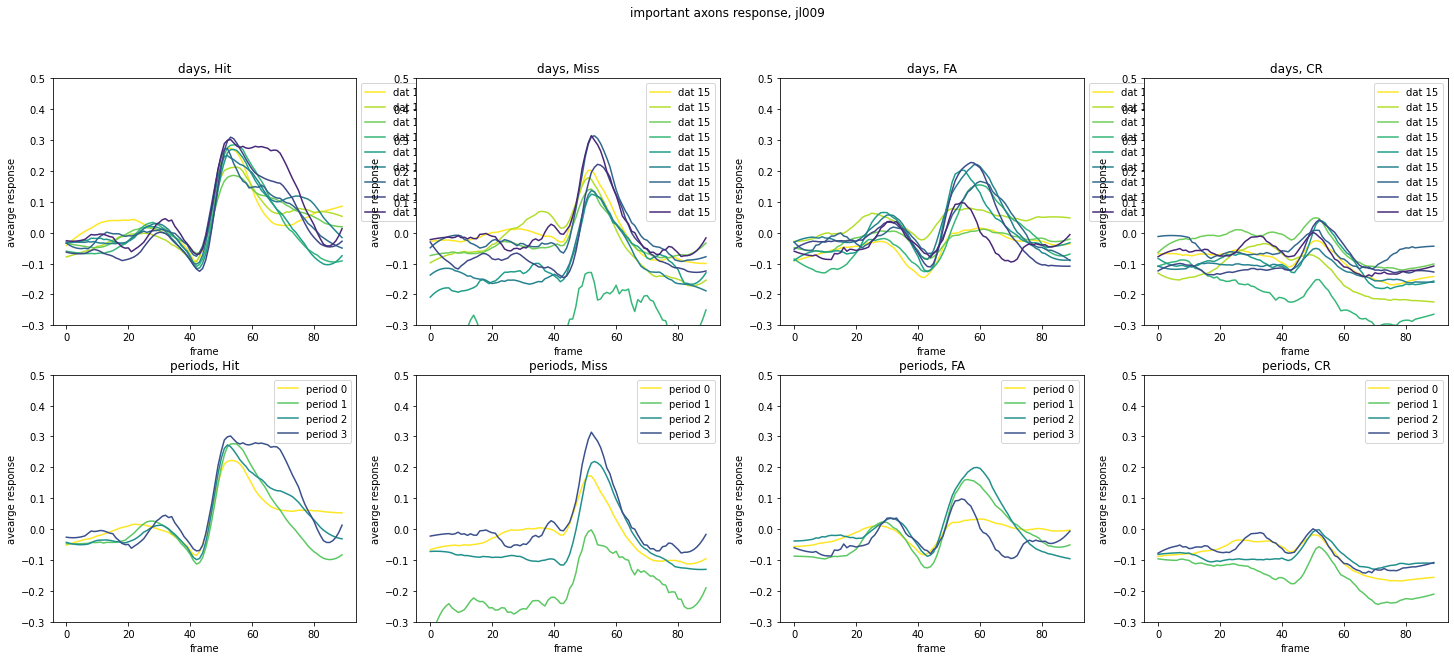

In [11]:
im = True
if im:
    resp_all = resp_all_im
else:
    resp_all = resp_all_nonim
    
day_groups = day_groups_all[mouse_id]
resp_all_period = np.zeros((len(day_groups), 4,  NF))
for outcome_index in range(4):
    for igroup, days in enumerate(day_groups):
        rsum = np.zeros(NF)
        for d in days:
            iday = np.where(d==np.array(valid_days))
            y = resp_all[iday, outcome_index]
            rsum += np.squeeze(y)
        rsum = rsum/len(days)
        resp_all_period[igroup, outcome_index] = rsum
# sum of with and without prelick, focus on the response after the stimulus.
cmap = plt.cm.get_cmap('viridis_r')
plt.figure(figsize=(25, 10))
for outcome_index in range(4):
    plt.subplot(2,4,outcome_index+1)
    for iday, days in enumerate(valid_days):
        y = resp_all[iday, outcome_index] 
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        y = savgol_filter(y, 13, 2)
        plt.plot(np.arange(NF), y, label='dat {}'.format(day), color=cmap(iday/len(valid_days)))
    # plt.legend()
    plt.title('days, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.subplot(2,4,outcome_index+5)
    for igroup, days in enumerate(day_groups):
        y = resp_all_period[igroup, outcome_index]
        y = savgol_filter(y, 13, 2)
        # min_resp = np.max(y[35:45])
        # y = y - min_resp
        plt.plot(np.arange(NF), y, label='period {}'.format(igroup), color=cmap(igroup/len(day_groups)))
    plt.legend()
    plt.title('periods, {}'.format(outcome_list[outcome_index]))
    plt.xlabel('frame')
    plt.ylabel('avearge response')
    plt.ylim([-0.3, 0.5])
    plt.legend(bbox_to_anchor=(1, 1))
    
if im:
    plt.suptitle('important axons response, {}'.format(mouse_name))
else:
    plt.suptitle('non important axons response, {}'.format(mouse_name))